In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('science')

# Folder directory for the data and figures of this notebook
data_folder = r'C:/Users/noedi/Desktop/lab_optique/data/faraday/data/' # à changer selon la personne 
figure_folder = r'C:/Users/noedi/Desktop/lab_optique/data/faraday/figures/' # à changer selon la personne 

### Semaine 1
On explore 2 parties principales cette semaine: 
- 1) Caractérisation du champ magnétique à l'intérieur de la bobine
- 2) Mesure de la constante de Verdet en courant continu avec 3 méthodes différentes

#### Caractérisation du champ magnétique à l'intérieur de la bobine
On a deux sous-parties par cette section.
1) Caractérisation de la variation spatiale du champ magnétique dans la bobine (comment le champ varie si on se déplace à l'intérieur de la bobine)
2) Caractérisation de la variation avec le courant du champ magnétique dans la bobine

In [18]:
def preprocess_B(raw_B, range = 30): 
    """
    Calcul la valeur de B en Gauss étant donné 
    """
    return raw_B * 10 * range * u.gauss.to(u.tesla)

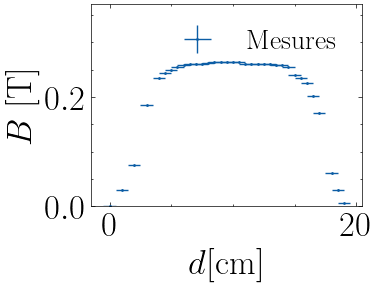

In [44]:
# Importer les données
data = np.loadtxt(data_folder + "d_vs_B.txt", skiprows=1)
D = data[:, 0] # cm 
B = preprocess_B(data[:, 1], range = 30) # Tesla

# Importer les incertitudes
std_data = np.loadtxt(data_folder + "incertitude.txt", skiprows=1)
std_B = preprocess_B(std_data[:, 1], range = 30).std(ddof = 1)# Tesla
std_Ib = preprocess_B(std_data[:, 0], range = 30).std(ddof = 1) # icnertitude courant bobine (A)
std_D = 0.5 # cm

plt.errorbar(D, B, xerr = 0.5, yerr = std_B, fmt = ".", label = "Mesures", markersize = 2)
plt.xlabel(r"$d$[cm]")
plt.ylabel(r"$B$ [T]")
# plt.xlim([0, 23])
plt.ylim([0, B.max() * 1.4])
plt.legend(loc = "upper right")

On note une région où le champ magnétique est presque constant vers le centre de la bobine ! Analysons maintenant comment ceci varie lorsqu'on varie l'intensité du courant à la place de la distance de la sonde dans la bobine. 

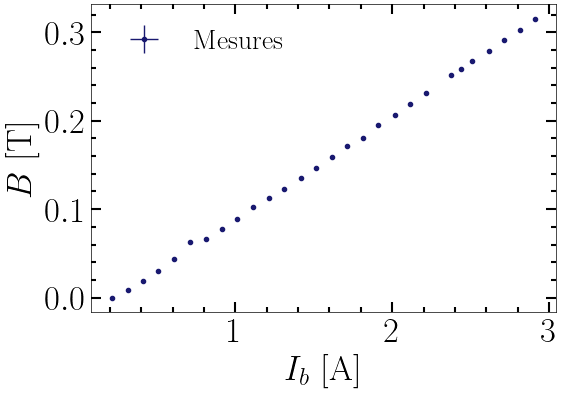

In [47]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
data = np.loadtxt(data_folder + "Ib_vs_B.txt", skiprows=1)
Ib = data[:, 0] # courant dans la bobine (A) 
B = preprocess_B(data[:, 1], range = 30) # Tesla

# incertitudes déjà importées cellule précédente.


fig, ax = plt.subplots(1, 1, figsize = (6, 4))

ax.errorbar(Ib, B, 
            fmt = ".", 
            xerr = std_Ib, 
            yerr = std_B, 
            color = "midnightblue",
            label = "Mesures")
ax.set(xlabel = r"$I_b$ [A]", ylabel = r"$B$ [T]")
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend()

On a une relation qui semble linéaire. Faisons un ajustement sur celle-ci afin de pouvoir obtenir le champ magnétique $B$ pour n'importe quel courant $I_b$. Cela revient à trouver les paramètres $\beta_0$ et $\beta_1$ pour la relation suivante
$$
B = \beta_0 I_b + \beta_1  
$$

In [58]:
def linear(x, params_fitted):
    a, b = params_fitted
    return a + b * x

x = Ib
y = B
sigma_y = std_B

Regression_bobine= FrequentistRegression(
    degree = 1,
    sigma_noise = 2 * sigma_y
)

params_fitted, std_fitted = Regression_bobine.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = True
)

y_pred = Regression_bobine.forward_model()
cov = Regression_bobine.cov
chi2 = Regression_bobine.compute_chi2(obs = y)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2)


The parameters fitted are [-0.02851079  0.11729722]
The std of the params fitted are [0.00059292 0.00033622]
The cov of the params fitted is [[ 3.51556996e-07 -1.76998364e-07]
 [-1.76998364e-07  1.13046581e-07]]
The chi squared is: 2.5382542559591355


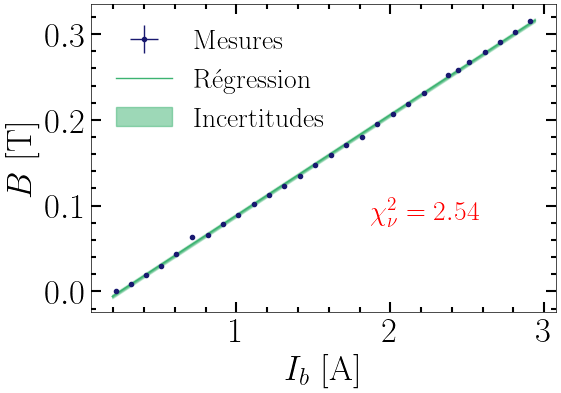

In [70]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

I_fit = np.linspace(0.9 * Ib.min(), 1.01 * Ib.max(), 500)
y_pred_fit = linear(I_fit, params_fitted=params_fitted)
ax.errorbar(Ib, B, 
            fmt = ".", 
            xerr = std_Ib, 
            yerr = std_B, 
            color = "midnightblue",
            label = "Mesures")
ax.plot(I_fit, y_pred_fit, label = "Régression", color = "mediumseagreen")

# k = 1
k = 1 
ax.fill_between(
    I_fit, 
    y_pred_fit - k * std_B,
    y_pred_fit + k * std_B,
    label = "Incertitudes", 
    color = "mediumseagreen", 
    alpha = 0.5
)

k = 3
ax.fill_between(
    I_fit, 
    y_pred_fit - k * std_B,
    y_pred_fit + k * std_B,
    color = "mediumseagreen", 
    alpha = 0.3
)
ax.set(xlabel = r"$I_b$ [A]", ylabel = r"$B$ [T]")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.6, 0.3), xycoords = "axes fraction", color = "red", fontsize = 20)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])

Parfait. Créons une fonction pour aller de $I_b$ (A) à $B$ (Tesla)

In [73]:
def Ib_to_B(x, params_reg = params_fitted): 
    """
    Ib (amperes) à B (Tesla)
    """
    a, b = params_reg
    return a + b * x

#### Mesure de la constante de Verdet

##### Méthode 1: Par extension (ajustement de l'angle des deux polariseurs)

In [ ]:
# Importer les données (d = 9 cm, i.e. au milieu de la bobine)
data = np.loadtxt(data_folder + "Ib_vs_B.txt", skiprows=1)
Ib = data[:, 0] # courant dans la bobine (A) 
B = preprocess_B(data[:, 1], range = 30) # Tesla

